# Weather Preprocessing

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview

In [5]:
import pandas as pd
import xarray as xr
from geographiclib.geodesic import Geodesic
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import glob
import folium

In [ ]:
# import data
df_path = '/home/miquel/SHARED/ryanair_miquel/df_fe.csv'
data_flights = pd.read_csv(df_path)

In [ ]:
nc_path = '/DATA1/SHARED/ryanair-study/data/weather_data/era5/2024-04-01/2021-08-01.nc'
data_weather = xr.open_dataset(nc_path)

In [ ]:
data_weather

<xarray.Dataset> Size: 5GB
Dimensions:                      (time: 24, level: 9, lat: 721, lon: 1440)
Coordinates:
  * time                         (time) datetime64[ns] 192B 2021-08-01 ... 20...
  * level                        (level) float64 72B 1e+03 900.0 ... 300.0 200.0
  * lat                          (lat) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * lon                          (lon) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    geopotential                 (time, level, lat, lon) float32 897MB ...
    specific_humidity            (time, level, lat, lon) float32 897MB ...
    temperature                  (time, level, lat, lon) float32 897MB ...
    wind_u                       (time, level, lat, lon) float32 897MB ...
    wind_v                       (time, level, lat, lon) float32 897MB ...
    specific_rain_water_content  (time, level, lat, lon) float32 897MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-01T18:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
data_flights.head(5)

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,...,Freight,Infants,Bags,PlannedZeroFuelWeight,PlannedTOW,PlannedTripTime,TeledyneRampWeight,FuelWeight,Distance,AircraftAge
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,...,0.0,2.0,43.0,56242.0,62723.0,8246.0,62075.0,6481.0,1.582254e+06,0.000000
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,2020-03-09 09:00:00,...,0.0,0.0,7.0,57148.0,63878.0,6227.0,62002.0,6730.0,1.186851e+06,0.000000
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,2020-01-06 07:35:00,...,0.0,0.0,19.0,53620.0,58089.0,3653.0,58029.0,4469.0,4.939575e+05,1.000000
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,2020-12-11 07:15:00,...,0.0,1.0,8.0,53396.0,58999.0,4784.0,56070.0,5603.0,8.125453e+05,0.000000
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,2020-02-07 15:20:00,...,0.0,0.0,47.0,59199.0,68573.0,9275.0,68315.0,9374.0,1.766642e+06,6.229273


## Fligt Data Preprocessing

Filter data_flights to extract the dates for which we have weather data (January 2022 & August 2021)

In [ ]:
def preprocess_flight_data(data_flights):
    # Convert 'DepartureScheduled' and 'ArrivalScheduled' to datetime
    data_flights['DepartureScheduled'] = pd.to_datetime(data_flights['DepartureScheduled'])
    data_flights['ArrivalScheduled'] = pd.to_datetime(data_flights['ArrivalScheduled'])

    # Filter for August 2021 and January 2022
    filtered_data = data_flights[
        ((data_flights['DepartureScheduled'].dt.month == 8) & (data_flights['DepartureScheduled'].dt.year == 2021)) |
        ((data_flights['DepartureScheduled'].dt.month == 1) & (data_flights['DepartureScheduled'].dt.year == 2022))
    ]

    return filtered_data

In [ ]:
data_flights = preprocess_flight_data(data_flights)

Airport Code Decoding for data_flight (Extract lon and lat for each airport)

In [ ]:
# Read airport data with info about lon and lat
iata_path = '/home/miquel/SHARED/ryanair_miquel/iata.csv'
iata_df = pd.read_csv(iata_path)

In [ ]:
# Extract Origin and Destination airport codes from the 'ScheduledRoute' column
data_flights[['OriginCode', 'DestinationCode']] = data_flights['ScheduledRoute'].str.split('-', expand=True)

# Create a dictionary for quick lookup of coordinates by airport code
coordinates_dict = iata_df.set_index('iata')[['longitude', 'latitude']].to_dict('index')

# Map airport code to longitude and latitude
def map_lon(code):
    return coordinates_dict.get(code, {}).get('longitude', None)

def map_lat(code):
    return coordinates_dict.get(code, {}).get('latitude', None)

# Map the Origin and Destination airport codes to their respective longitude and latitude
data_flights['OriginLon'] = data_flights['OriginCode'].apply(map_lon)
data_flights['OriginLat'] = data_flights['OriginCode'].apply(map_lat)
data_flights['DestinationLon'] = data_flights['DestinationCode'].apply(map_lon)
data_flights['DestinationLat'] = data_flights['DestinationCode'].apply(map_lat)

### Visualize coordinates in a map

In [ ]:
# Extract unique origin and destination coordinates
unique_origins = data_flights[['OriginLat', 'OriginLon']].dropna().drop_duplicates()
unique_destinations = data_flights[['DestinationLat', 'DestinationLon']].dropna().drop_duplicates()

# Create a base map
map = folium.Map(location=[data_flights['OriginLat'].mean(), data_flights['OriginLon'].mean()], zoom_start=5)

# Add markers for unique Origin points with darkblue color
for _, row in unique_origins.iterrows():
    folium.Marker(
        location=[row['OriginLat'], row['OriginLon']],
        popup='Origin',
        icon=folium.Icon(color='darkblue', icon='info-sign')
    ).add_to(map)

# Add markers for unique Destination points with darkred color
for _, row in unique_destinations.iterrows():
    folium.Marker(
        location=[row['DestinationLat'], row['DestinationLon']],
        popup='Destination',
        icon=folium.Icon(color='darkred', icon='info-sign')
    ).add_to(map)

# Display the map
map

## Coordinates Preprocessing

Create Geodesic Lines and Sampling Points for Routes

https://www.gpxz.io/blog/sampling-points-on-a-line

In [ ]:
def path_points(origin, destination, n_samples=10):
    path = [origin, destination]
    geod = Geodesic.WGS84

    # Calculate distance between path coordinates
    path_distance = [0]
    for (start_lat, start_lon), (end_lat, end_lon) in zip(path[:-1], path[1:]):
        path_distance.append(geod.Inverse(start_lat, start_lon, end_lat, end_lon)['s12'])

    path_distance_cum = np.cumsum(path_distance)
    point_distance = np.linspace(0, path_distance_cum[-1], n_samples)

    points = []
    for pd in point_distance:
        # Find segment index
        index_array = np.argwhere(pd >= path_distance_cum)[:, 0]
        if index_array.size > 0:
            i_start = index_array[-1]
        else:
            points.append((0, 0))
            continue

        # Early exit for ends
        if np.isclose(pd, path_distance_cum[i_start]):
            points.append(path[i_start])
            continue
        elif np.isclose(pd, path_distance_cum[-1]):
            points.append(path[-1])
            continue

        # Distance along segment
        start_lat, start_lon = path[i_start]
        end_lat, end_lon = path[i_start + 1]
        pd_between = pd - path_distance_cum[i_start]

        # Location along segment
        line = geod.InverseLine(start_lat, start_lon, end_lat, end_lon)
        g_point = line.Position(pd_between, Geodesic.STANDARD | Geodesic.LONG_UNROLL)
        points.append((g_point['lat2'], g_point['lon2']))

    return points

In [ ]:
def expand_points(row, n_samples):
    origin = (row['OriginLat'], row['OriginLon'])
    destination = (row['DestinationLat'], row['DestinationLon'])
    expanded_points = path_points(origin, destination, n_samples)

    point_data = {}
    for i, point in enumerate(expanded_points, start=1):
        point_data[f'Point_{i}_Lat'] = point[0]
        point_data[f'Point_{i}_Lon'] = point[1]

    return pd.Series(point_data)

n_samples = 10
new_columns = [f'Point_{i}_Lat' for i in range(1, n_samples + 1)] + [f'Point_{i}_Lon' for i in range(1, n_samples + 1)]
sampled_points_df = data_flights.apply(lambda row: expand_points(row, n_samples), axis=1)

In [ ]:
# Concatenate the new columns
data_flights = pd.concat([data_flights, sampled_points_df], axis=1)

In [ ]:
data_flights.head(5)

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,...,Point_6_Lat,Point_6_Lon,Point_7_Lat,Point_7_Lon,Point_8_Lat,Point_8_Lon,Point_9_Lat,Point_9_Lon,Point_10_Lat,Point_10_Lon
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,...,50.278456,10.691844,49.627188,12.925370,48.933909,15.098271,48.200746,17.210146,47.4298,19.26110
14,180772692,2625,EIGXI,189.0,NG,Scheduled Flight,FR,Ryanair DAC,LIS-PDL,2021-08-03 21:15:00,...,38.493047,-18.398114,38.347813,-20.236453,38.173879,-22.066743,37.971555,-23.887649,37.7412,-25.69790
34,181085323,3068,9HQAH,189.0,NG,Scheduled Flight,FR,Malta Air,FCO-BRI,2021-08-04 14:15:00,...,41.454797,14.762356,41.379082,15.263711,41.301187,15.763889,41.221122,16.262860,41.1389,16.76060
43,181227214,2998,EIDHY,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-AMS,2022-01-07 18:35:00,...,52.929602,-0.069105,52.792920,1.151686,52.643757,2.364501,52.482264,3.568754,52.3086,4.76389
61,181386758,7654,SPRSL,189.0,NG,Scheduled Flight,FR,Ryanair Sun,EIN-VNO,2022-01-07 14:00:00,...,53.633231,16.075748,53.949061,18.334439,54.221793,20.625149,54.450427,22.943771,54.6341,25.28580


In [ ]:
# Remove all the rows where coordinates couldnt be identified
mask = data_flights.filter(like='Point_').eq(0).any(axis=1)
data_flights = data_flights[~mask]

In [ ]:
# Reset index of data_flights
data_flights.reset_index(drop=True, inplace=True)

In [ ]:
# Round Point columns to nearts quarter to align with weather data
def round_to_nearest_quarter(value):
    return round(value * 4) / 4

for column in data_flights.columns:
    if column.startswith('Point_'):
        data_flights[column] = data_flights[column].apply(round_to_nearest_quarter)

In [ ]:
data_flights.head(5)

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,...,Point_6_Lat,Point_6_Lon,Point_7_Lat,Point_7_Lon,Point_8_Lat,Point_8_Lon,Point_9_Lat,Point_9_Lon,Point_10_Lat,Point_10_Lon
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,...,50.25,10.75,49.75,13.00,49.00,15.00,48.25,17.25,47.50,19.25
1,180772692,2625,EIGXI,189.0,NG,Scheduled Flight,FR,Ryanair DAC,LIS-PDL,2021-08-03 21:15:00,...,38.50,-18.50,38.25,-20.25,38.25,-22.00,38.00,-24.00,37.75,-25.75
2,181085323,3068,9HQAH,189.0,NG,Scheduled Flight,FR,Malta Air,FCO-BRI,2021-08-04 14:15:00,...,41.50,14.75,41.50,15.25,41.25,15.75,41.25,16.25,41.25,16.75
3,181227214,2998,EIDHY,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-AMS,2022-01-07 18:35:00,...,53.00,0.00,52.75,1.25,52.75,2.25,52.50,3.50,52.25,4.75
4,181386758,7654,SPRSL,189.0,NG,Scheduled Flight,FR,Ryanair Sun,EIN-VNO,2022-01-07 14:00:00,...,53.75,16.00,54.00,18.25,54.25,20.75,54.50,23.00,54.75,25.25


In [ ]:
# Remove aircraft types that aren't NG so it doesnt bias our prediction
data_flights = data_flights[data_flights["AircraftTypeGroup"] == "NG"]
data_flights.reset_index(drop=True, inplace=True)

In [ ]:
# Remove time from Departure Scheduled, only keep the date to align with weather data file names
data_flights['DepartureScheduled'] = data_flights['DepartureScheduled'].dt.date

In [ ]:
data_flights

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,...,Point_6_Lat,Point_6_Lon,Point_7_Lat,Point_7_Lon,Point_8_Lat,Point_8_Lon,Point_9_Lat,Point_9_Lon,Point_10_Lat,Point_10_Lon
0,180772692,2625,EIGXI,189.0,NG,Scheduled Flight,FR,Ryanair DAC,LIS-PDL,2021-08-03,...,38.50,-18.50,38.25,-20.25,38.25,-22.00,38.00,-24.00,37.75,-25.75
1,181085323,3068,9HQAH,189.0,NG,Scheduled Flight,FR,Malta Air,FCO-BRI,2021-08-04,...,41.50,14.75,41.50,15.25,41.25,15.75,41.25,16.25,41.25,16.75
2,181227214,2998,EIDHY,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-AMS,2022-01-07,...,53.00,0.00,52.75,1.25,52.75,2.25,52.50,3.50,52.25,4.75
3,181386758,7654,SPRSL,189.0,NG,Scheduled Flight,FR,Ryanair Sun,EIN-VNO,2022-01-07,...,53.75,16.00,54.00,18.25,54.25,20.75,54.50,23.00,54.75,25.25
4,181265230,4170,EIDLC,189.0,NG,Scheduled Flight,FR,Ryanair DAC,FAO-FRA,2022-01-04,...,44.50,0.25,46.00,2.25,47.25,4.25,48.75,6.25,50.00,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63796,181337728,6325,EIEBL,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-MXP,2022-01-25,...,49.25,2.75,48.50,4.25,47.50,5.75,46.50,7.25,45.75,8.75
63797,181285174,4697,EIEXD,189.0,NG,Scheduled Flight,FR,Ryanair DAC,ALC-ACE,2022-01-24,...,33.25,-8.25,32.25,-9.50,31.25,-11.00,30.00,-12.25,29.00,-13.50
63798,181222953,2910,9HQBQ,189.0,NG,Scheduled Flight,FR,Malta Air,GOA-PMO,2022-01-06,...,41.00,11.25,40.25,11.75,39.50,12.25,39.00,12.75,38.25,13.00
63799,180852971,5520,9HQBJ,189.0,NG,Scheduled Flight,FR,Malta Air,CTA-MXP,2021-08-14,...,42.00,11.75,43.00,11.00,43.75,10.25,44.75,9.50,45.75,8.75


### Sample to Visualize Dublin - Amsterdam

In [6]:
path = [
    (53.4213, -6.27007),
    (52.3086, 4.76389),
]

n_samples = 10

# Distance between each path coord.
geod = Geodesic.WGS84
path_distance = [0]
for (start_lat, start_lon), (end_lat, end_lon) in zip(path[:-1], path[1:]):
    path_distance.append(geod.Inverse(start_lat, start_lon, end_lat, end_lon)['s12'])

path_distance_cum = np.cumsum(path_distance)
point_distance = np.linspace(0, path_distance_cum[-1], n_samples)

points = []
for pd in point_distance:

    # Find segment with.
    i_start = np.argwhere(pd >= path_distance_cum)[:, 0][-1]

    # Early exit for ends.
    if np.isclose(pd, path_distance_cum[i_start]):
        points.append(path[i_start])
        continue
    elif np.isclose(pd, path_distance_cum[-1]):
        points.append(path[-1])
        continue

    # Distance along segment.
    start_lat, start_lon = path[i_start]
    end_lat, end_lon = path[i_start + 1]
    pd_between = pd - path_distance_cum[i_start]

    # Location along segment.
    line = geod.InverseLine(start_lat, start_lon, end_lat, end_lon)
    g_point = line.Position(pd_between, Geodesic.STANDARD | Geodesic.LONG_UNROLL)
    points.append((g_point['lat2'], g_point['lon2']))

In [7]:
points

[(53.4213, -6.27007),
 (53.34889112232538, -5.019230126176522),
 (53.263418654683846, -3.7730026815524007),
 (53.16497445272717, -2.5321101885719752),
 (53.05366326635472, -1.2972526263375581),
 (52.929602205388846, -0.06910488007901883),
 (52.79292015373259, 1.1516855612180406),
 (52.6437571386192, 2.3645006437195475),
 (52.482263661841394, 3.5687535133824744),
 (52.3086, 4.76389)]

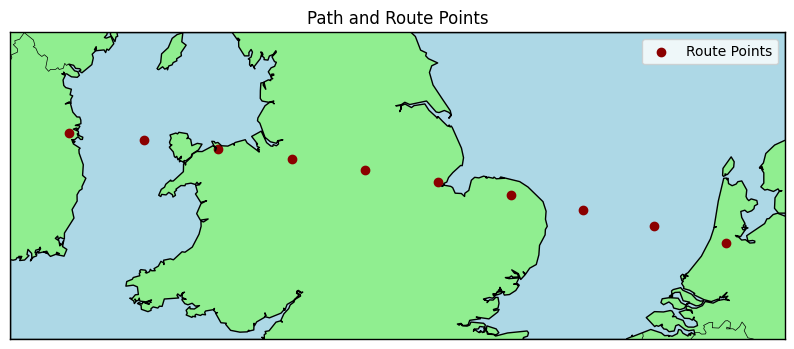

In [9]:
lats, lons = zip(*path)
sample_lats, sample_lons = zip(*points)

# Plotting
plt.figure(figsize=(10, 6))
m = Basemap(projection='merc', llcrnrlat=min(lats)-1, urcrnrlat=max(lats)+1, llcrnrlon=min(lons)-1, urcrnrlon=max(lons)+1, resolution='i')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgreen', lake_color='lightblue')

# Plot the sampled points
x_samples, y_samples = m(sample_lons, sample_lats)
m.scatter(x_samples, y_samples, marker='o', color='darkred', label='Route Points')

plt.title('Path and Route Points')
plt.legend()
plt.show()

## Weather Data Preprocessing

Retrive weather data at specified points and pressure level and compute mean value for route

In [ ]:
def load_weather_data(weather_data_folder, departure_date):

    weather_file = f'{weather_data_folder}{departure_date}.nc'
    data_weather = xr.open_dataset(weather_file)

    return data_weather

In [ ]:
def compute_mean_weather_for_flight(flight_row, data_weather, n_samples=10):

    # Initialize lists to store weather parameter values for each sampled point
    geopotential, specific_humidity, temperature, wind_u, wind_v, specific_rain = ([] for _ in range(6))
    wind_speed, wind_direction = [], []

    # Sample weather data for each of the points and store the values
    for i in range(1, n_samples + 1):
        lat_col, lon_col = f'Point_{i}_Lat', f'Point_{i}_Lon'
        lat, lon = flight_row[lat_col], flight_row[lon_col]

        # Sample weather data at the specified point and level (200 hPa)
        weather_sample = data_weather.sel(lat=lat, lon=lon, level=200, method='nearest')

        # Append sampled values to respective lists
        u_component = weather_sample.wind_u.values
        v_component = weather_sample.wind_v.values

        geopotential.append(weather_sample.geopotential.values)
        specific_humidity.append(weather_sample.specific_humidity.values)
        temperature.append(weather_sample.temperature.values)
        wind_u.append(u_component)
        wind_v.append(v_component)
        specific_rain.append(weather_sample.specific_rain_water_content.values)

        # Calculate and append wind speed and direction for each point
        speed = np.sqrt(u_component**2 + v_component**2)
        direction = np.degrees(np.arctan2(v_component, u_component)) % 360  # Convert to degrees to ensure 0-360 range

        wind_speed.append(speed)
        wind_direction.append(direction)

    # Compute mean values for each weather parameter including wind speed and direction
    mean_values = {
        'GeopotentialMean': np.mean(geopotential),
        'SpecificHumidityMean': np.mean(specific_humidity),
        'TemperatureMean': np.mean(temperature),
        'WindUMean': np.mean(wind_u),
        'WindVMean': np.mean(wind_v),
        'SpecificRainWaterContentMean': np.mean(specific_rain),
        'WindSpeedMean': np.mean(wind_speed),
        'WindDirectionMean': np.mean(wind_direction)
    }

    return mean_values

In [ ]:
def integrate_weather_into_flights(data_flights, weather_data_folder):
    weather_params = ['GeopotentialMean', 'SpecificHumidityMean', 'TemperatureMean', 'WindUMean', 'WindVMean', 'SpecificRainWaterContentMean']

    for param in weather_params:
        data_flights[param] = np.nan

    loaded_weather_data = {}

    total_rows = len(data_flights)
    print(f"Processing {total_rows} rows...")

    # Compute mean weather parameters for each flight and update the DataFrame
    for index, row in data_flights.iterrows():
        departure_date = row['DepartureScheduled'].strftime('%Y-%m-%d')

        # Load weather data if not already loaded for this date
        if departure_date not in loaded_weather_data:
            loaded_weather_data[departure_date] = load_weather_data(weather_data_folder, departure_date)

        # Pass the loaded weather data to the compute_mean_weather_for_flight function
        mean_weather = compute_mean_weather_for_flight(row, loaded_weather_data[departure_date])

        # Update with the mean weather parameters
        for param, value in mean_weather.items():
            data_flights.at[index, param] = value

        # Update progress bar
        progress = (index / total_rows) * 100
        bar_length = 50
        filled_length = int(bar_length * index // total_rows)
        bar = '#' * filled_length + '-' * (bar_length - filled_length)
        print(f'\rProgress: |{bar}| {progress:.2f}% Complete', end='\r')
        if index == total_rows:
            print()

In [ ]:

folder_path = '/DATA1/SHARED/ryanair-study/data/weather_data/era5/2024-04-01/'
integrate_weather_into_flights(data_flights, folder_path)

Processing 63801 rows...


In [ ]:
data_flights

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,...,Point_10_Lat,Point_10_Lon,GeopotentialMean,SpecificHumidityMean,TemperatureMean,WindUMean,WindVMean,SpecificRainWaterContentMean,WindSpeedMean,WindDirectionMean
0,180772692,2625,EIGXI,189.0,NG,Scheduled Flight,FR,Ryanair DAC,LIS-PDL,2021-08-03,...,37.75,-25.75,120668.148438,0.000026,218.824234,12.724286,-8.266008,0.0,15.483874,328.617249
1,181085323,3068,9HQAH,189.0,NG,Scheduled Flight,FR,Malta Air,FCO-BRI,2021-08-04,...,41.25,16.75,120620.804688,0.000025,218.656036,21.794788,4.225658,0.0,23.060280,116.843651
2,181227214,2998,EIDHY,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-AMS,2022-01-07,...,52.25,4.75,111220.023438,0.000004,219.618820,23.252052,-2.642132,0.0,27.727110,188.627533
3,181386758,7654,SPRSL,189.0,NG,Scheduled Flight,FR,Ryanair Sun,EIN-VNO,2022-01-07,...,54.75,25.25,111785.093750,0.000008,213.901276,23.128908,2.074437,0.0,27.040560,142.265823
4,181265230,4170,EIDLC,189.0,NG,Scheduled Flight,FR,Ryanair DAC,FAO-FRA,2022-01-04,...,50.00,8.50,115587.617188,0.000015,210.842499,32.905899,15.181388,0.0,37.389080,46.146183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63796,181337728,6325,EIEBL,189.0,NG,Scheduled Flight,FR,Ryanair DAC,DUB-MXP,2022-01-25,...,45.75,8.75,115292.031250,0.000006,209.315750,5.968081,-3.761387,0.0,8.526136,282.701691
63797,181285174,4697,EIEXD,189.0,NG,Scheduled Flight,FR,Ryanair DAC,ALC-ACE,2022-01-24,...,29.00,-13.50,115963.804688,0.000009,216.321838,19.821367,-8.451189,0.0,21.776564,333.086456
63798,181222953,2910,9HQBQ,189.0,NG,Scheduled Flight,FR,Malta Air,GOA-PMO,2022-01-06,...,38.25,13.00,113654.078125,0.000006,220.390167,8.073931,3.468274,0.0,14.362510,127.570099
63799,180852971,5520,9HQBJ,189.0,NG,Scheduled Flight,FR,Malta Air,CTA-MXP,2021-08-14,...,45.75,8.75,121250.828125,0.000021,217.320404,1.234045,-10.538422,0.0,13.604836,276.257050
